In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [128]:
trade_dir = os.path.join('..', 'data_files', 'backtest_data', 'results')
value_df_entries = []
trade_df_entries = []
value_df_cols = ['Buy_Cutoff', 'Sell_Cutoff', 'Max_Invest', 'Median_Weekly_Change', 'Mean_Weekly_Change', 'Final_Value']
trade_df_cols = ['Buy_Cutoff', 'Sell_Cutoff', 'Max_Invest', 'Buy Pct', 'Sell Pct']

bad_ids = [
    'trade_1.005_0.995_0.100.csv',
    'value_1.005_0.995_0.100.csv',
    'trade_1.005_0.000_0.100.csv',
    'value_1.005_0.000_0.100.csv'
]

## Read in all the dataframes from trade_dir
## - Result will be a trade_df and a value_df
## - We will join the results to get % buy % short
for name in os.listdir(trade_dir):
    if name in bad_ids:
        continue
    tokens = name.split('_')
    buy_cut = float(tokens[1])
    sell_cut = float(tokens[2])
    max_invest = float(tokens[3][:5])
    df = pd.read_csv(os.path.join(trade_dir, name))
    if tokens[0] == 'value':
        final_value = df['value'].iloc[len(df) - 1]
        weekly_change = df['value'].values[1:] / df['value'].values[:len(df) - 1]
        median_weekly_change = np.median(weekly_change)
        mean_weekly_change = np.mean(weekly_change)
        value_df_entries.append((buy_cut, sell_cut, max_invest, median_weekly_change, mean_weekly_change, final_value))
    else:
        buy_pct = (df['position'] == 'buy').mean()
        sell_pct = 1 - buy_pct
        trade_df_entries.append((buy_cut, sell_cut, max_invest, buy_pct, sell_pct))

trade_df = pd.DataFrame(trade_df_entries, columns=trade_df_cols)
value_df = pd.DataFrame(value_df_entries, columns=value_df_cols)
my_df = pd.merge(trade_df, value_df, on=['Buy_Cutoff', 'Sell_Cutoff', 'Max_Invest'], how='inner')

In [129]:
# There was weird behavior when training the model, 0 shouldn't be in this column
my_df = my_df.loc[my_df['Sell_Cutoff'] > 0.8]

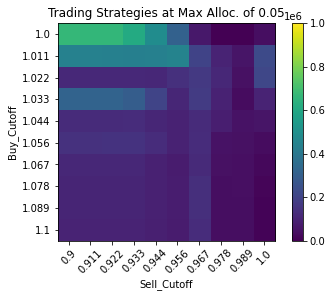

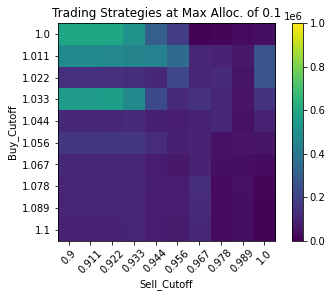

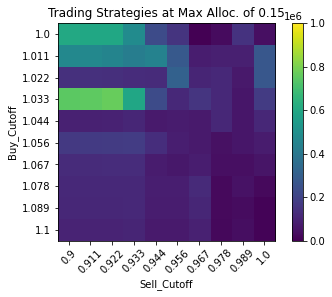

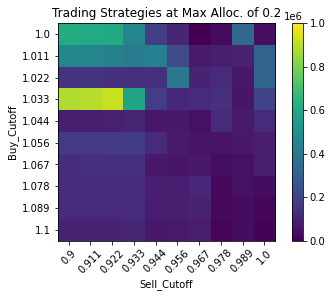

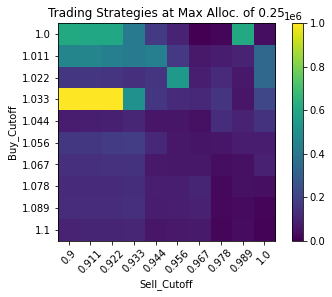

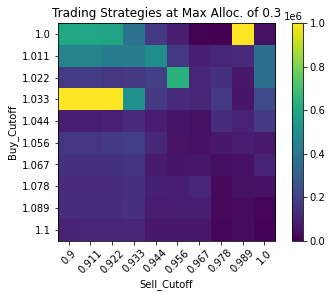

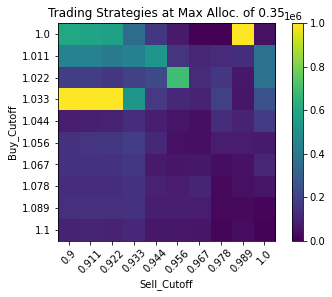

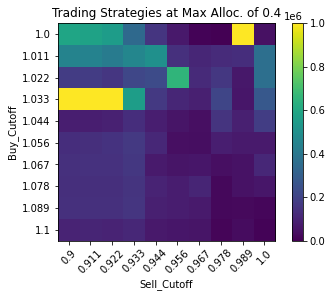

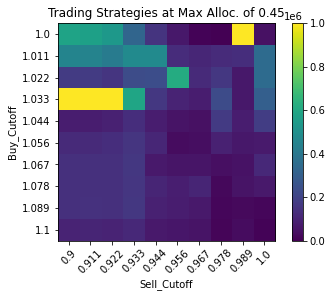

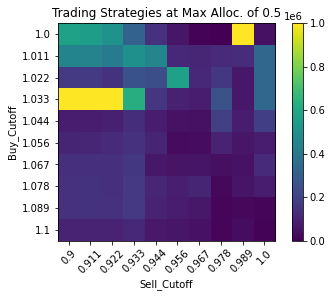

In [130]:
unique_allocs = my_df['Max_Invest'].unique()

for mi, df in my_df.groupby('Max_Invest'):
    fig, ax = plt.subplots()
    cur_df = df.set_index(['Buy_Cutoff', 'Sell_Cutoff'])['Final_Value'].unstack()
    cbar = ax.imshow(cur_df.values, vmin=0, vmax=1000000)
    
    ax.set_xticks(np.arange(len(cur_df.columns)))
    ax.set_yticks(np.arange(len(cur_df)))
    ax.set_xticklabels(cur_df.columns.values, rotation=45)
    ax.set_yticklabels(cur_df.index.values)
    
    ax.set_xlabel('Sell_Cutoff')
    ax.set_ylabel('Buy_Cutoff')
    ax.set_title('Trading Strategies at Max Alloc. of ' + str(mi))
    
    fig.colorbar(cbar)
    

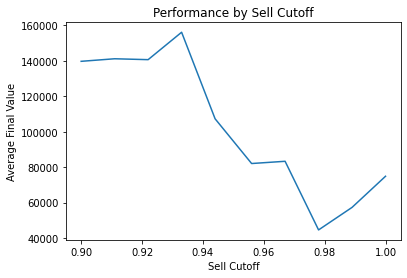

In [131]:
sell = my_df.groupby('Sell_Cutoff').agg(AVG_VALUE=('Final_Value', 'median'))

fig, ax = plt.subplots()
ax.set_title('Performance by Sell Cutoff')
ax.set_ylabel('Average Final Value')
ax.set_xlabel('Sell Cutoff')
ax.plot(sell.index.values, sell['AVG_VALUE'].values)


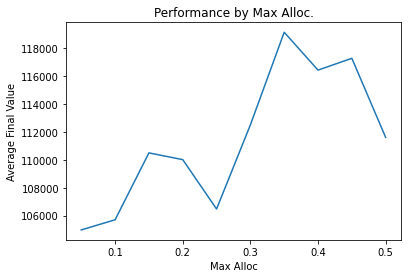

In [132]:
inv = my_df.groupby('Max_Invest').agg(AVG_VALUE=('Final_Value', 'median'))


fig, ax = plt.subplots()
ax.set_title('Performance by Max Alloc.')
ax.set_ylabel('Average Final Value')
ax.set_xlabel('Max Alloc')
ax.plot(inv.index.values, inv['AVG_VALUE'].values)



## Our Data Has a Lot of Outliars. To find a consistantly well performing strategy, we can try to identify median weekly change

In [133]:
def get_outlier_bounds(arr, k=3):
    quantiles = np.quantile(arr, [0.25, 0.75])
    lb = quantiles[0] - k * (quantiles[1] - quantiles[0])
    ub = quantiles[1] + k * (quantiles[1] - quantiles[0])
    return lb, ub

## We should drop the outliar strategies to find a strategy that might generalize well to a testing set
wc_lb, wc_ub = get_outlier_bounds(my_df['Median_Weekly_Change'])
fv_lb, fv_ub = get_outlier_bounds(my_df['Final_Value'])

wcl_pred = my_df['Median_Weekly_Change'] > wc_lb
wcu_pred = my_df['Median_Weekly_Change'] < wc_ub
fvl_pred = my_df['Final_Value'] > fv_lb
fvu_pred = my_df['Final_Value'] < fv_ub
clean_df = my_df.loc[wcl_pred & wcu_pred & fvl_pred & fvu_pred].copy()

## We can say that the best performing stock is the one that has the highest median weekly change whos studentized residual is not an outlier. 


In [134]:
X = np.concatenate([clean_df['Median_Weekly_Change'].values[:, None], np.full((len(clean_df), 1), 1.0)], axis=1)
Y = clean_df['Final_Value'].values[:, None]
H = X @ np.linalg.inv(X.T @ X) @ X.T
b = np.linalg.solve(X.T @ X, X.T @ Y)
y_pred = X @ b
resid = y_pred - Y
resid_var = 1 / (X.shape[0] - X.shape[1]) * (resid ** 2).sum()
stu_resid = resid / np.sqrt(resid_var - resid_var * H.diagonal())
clean_df['Estimates'] = y_pred[:, 0]
clean_df['Stu_Resid'] = stu_resid[:, 0]

Correlation 0.05958638221332909


Text(0.5, 1.0, 'Median Weekly Change and Final Value')

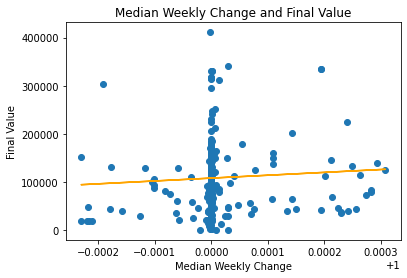

In [135]:
## How well does median weekly change correlate with final value
print('Correlation', clean_df['Median_Weekly_Change'].corr(clean_df['Final_Value']))
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(clean_df['Median_Weekly_Change'].values, clean_df['Final_Value'].values)
ax.plot(clean_df['Median_Weekly_Change'].values, y_pred, color='orange')
ax.set_xlabel('Median Weekly Change')
ax.set_ylabel('Final Value')
ax.set_title('Median Weekly Change and Final Value')


## Analysis of Mean Weekly Change
- Its just as volitile as looking at final values themselves
- There is a clear exponential relationship, its almost perfect
- Median weekly change is the most reliable measure

In [136]:
X = np.concatenate([my_df['Mean_Weekly_Change'].values[:, None], np.full((len(my_df), 1), 1.0)], axis=1)
Y = my_df['Final_Value'].values[:, None]
H = X @ np.linalg.inv(X.T @ X) @ X.T
b = np.linalg.solve(X.T @ X, X.T @ Y)
y_pred = X @ b
resid = y_pred - Y
resid_var = 1 / (X.shape[0] - X.shape[1]) * (resid ** 2).sum()
stu_resid = resid / np.sqrt(resid_var - resid_var * H.diagonal())
my_df['Estimates'] = y_pred[:, 0]
my_df['Stu_Resid'] = stu_resid[:, 0]

Correlation 0.6284839683318065


Text(0.5, 1.0, 'Mean Weekly Change and Final Value')

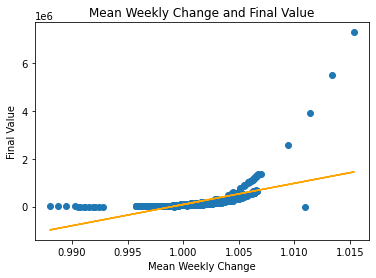

In [137]:
## How well does median weekly change correlate with final value
print('Correlation', my_df['Mean_Weekly_Change'].corr(my_df['Final_Value']))
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(my_df['Mean_Weekly_Change'].values, my_df['Final_Value'].values)
ax.plot(my_df['Mean_Weekly_Change'].values, y_pred, color='orange')
ax.set_xlabel('Mean Weekly Change')
ax.set_ylabel('Final Value')
ax.set_title('Mean Weekly Change and Final Value')


In [138]:
'''
Plots the value df for the given parameters on the given axis with the given
color and label
'''
def create_value_plot(ax, row, rgb, label_col, label_fmt = '%s'):
    buy_cut = row['Buy_Cutoff']
    sell_cut = row['Sell_Cutoff']
    max_invest = row['Max_Invest']
    label = label_fmt % row[label_col]
    
    file_id = "%05.03f" % buy_cut + "_"
    file_id += "%05.03f" % sell_cut + "_"
    file_id += "%05.03f" % max_invest
    
    print(file_id)
    
    val_df = pd.read_csv(os.path.join('..', 'data_files', 'backtest_data', 'results', 'value_'+ file_id + '.csv'))
    val_df['date'] = pd.to_datetime(val_df['date'])
    ax.plot(val_df['date'].values, val_df['value'].values, color=rgb, label=label)

1.022_0.956_0.350
1.022_0.956_0.300
1.022_0.956_0.400
1.022_0.967_0.200
1.022_0.967_0.150
1.011_0.944_0.300
1.033_1.000_0.350
1.011_1.000_0.350
1.022_1.000_0.350
1.044_0.989_0.350


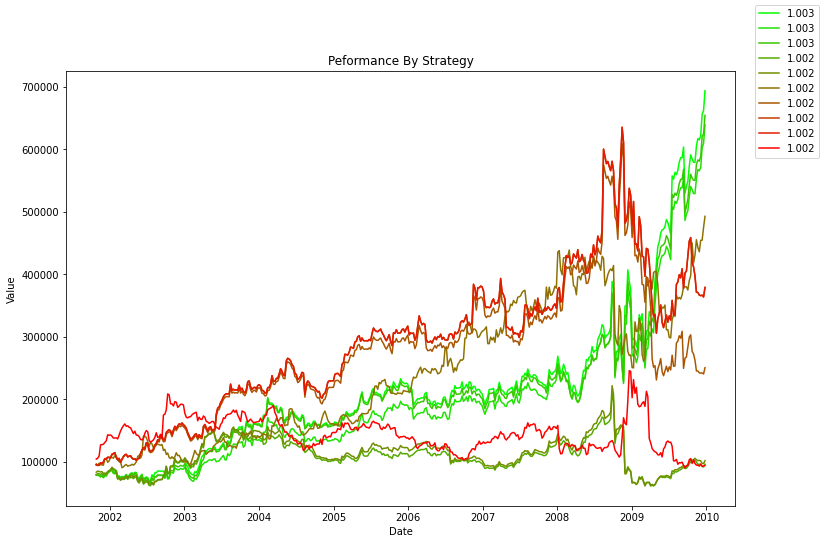

In [145]:
n_plot = 10
red = np.linspace(0, 1, n_plot)
green = 1 - red
blue = np.full((n_plot,), 0.0)
colors = list(zip(red, green, blue))
fig = plt.figure()
ax = fig.add_subplot()
to_plot = my_df.sort_values('Median_Weekly_Change', ascending=False)

for i in range(n_plot):
    create_value_plot(ax, to_plot.iloc[i], colors[i], 'Median_Weekly_Change', label_fmt='%05.03f')

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Peformance By Strategy')
fig.set_size_inches(12, 8)
fig.legend()
    

In [140]:
to_plot.iloc[:n_plot]

,Buy_Cutoff,Sell_Cutoff,Max_Invest,Buy Pct,Sell Pct,Median_Weekly_Change,Mean_Weekly_Change,Final_Value,Estimates,Stu_Resid
858,1.022,0.956,0.35,0.843666,0.156334,1.002883,1.006520,693736.351485,669506.274064,-0.082932
482,1.022,0.956,0.30,0.843666,0.156334,1.002827,1.006261,638848.105252,646483.754562,0.026135
43,1.022,0.956,0.40,0.843666,0.156334,1.002541,1.006377,654321.247431,656846.535781,0.008643
514,1.022,0.967,0.20,0.578523,0.421477,1.002242,1.001875,96034.498197,256632.236175,0.549679
431,1.022,0.967,0.15,0.578523,0.421477,1.002010,1.001873,101708.498578,256457.073519,0.529659
166,1.011,0.944,0.30,0.982356,0.017644,1.001965,1.005186,492639.751215,550950.672682,0.199581
70,1.033,1.000,0.35,0.047244,0.952756,1.001962,1.003268,250413.684597,380509.992092,0.445282
273,1.011,1.000,0.35,0.212137,0.787863,1.001952,1.004145,378892.492451,458429.472190,0.272232
218,1.022,1.000,0.35,0.103073,0.896927,1.001952,1.004145,378892.938004,458429.519836,0.272231
667,1.044,0.989,0.35,0.036402,0.963598,1.001887,1.001045,94078.049744,182919.228083,0.304077


## Performance by shorting percentage
- Lets find the best performing stock in terms of Median Weekly Change
- Examine a constant max_invest

In [141]:
# Shoule Examine a constant Max_invest value
const_invest = my_df.loc[my_df['Max_Invest'] == 0.35].copy()
const_invest['Sell_Bins'] = pd.cut(const_invest['Sell Pct'], np.arange(0, 1.01, 0.1))
max_perform = const_invest.groupby('Sell_Bins').apply(lambda df: df.loc[df['Median_Weekly_Change'] == df['Median_Weekly_Change'].max()].iloc[0]).reset_index(drop=True)
max_perform.sort_values('Sell_Bins')

,Buy_Cutoff,Sell_Cutoff,Max_Invest,Buy Pct,Sell Pct,Median_Weekly_Change,Mean_Weekly_Change,Final_Value,Estimates,Stu_Resid,Sell_Bins
0,1.011,0.911,0.35,0.999932,0.000068,1.001704,1.004781,442950.526493,514968.231177,0.246496,"(0.0, 0.1]"
1,1.022,0.956,0.35,0.843666,0.156334,1.002883,1.006520,693736.351485,669506.274064,-0.082932,"(0.1, 0.2]"
2,1.067,0.933,0.35,0.781676,0.218324,1.000000,1.001478,161417.542124,221392.098193,0.205275,"(0.2, 0.3]"
3,1.056,0.944,0.35,0.645400,0.354600,1.000000,1.001244,115903.436578,200608.974598,0.289922,"(0.3, 0.4]"
4,1.022,0.967,0.35,0.578523,0.421477,1.001272,1.002594,121379.482677,320548.710327,0.681698,"(0.4, 0.5]"
5,1.044,0.956,0.35,0.496862,0.503138,1.000000,0.999550,57183.746583,49994.647109,-0.024606,"(0.5, 0.6]"
6,1.022,0.978,0.35,0.326269,0.673731,1.001243,1.002785,160960.749690,337546.322506,0.604401,"(0.6, 0.7]"
7,1.011,1.000,0.35,0.212137,0.787863,1.001952,1.004145,378892.492451,458429.472190,0.272232,"(0.7, 0.8]"
8,1.022,1.000,0.35,0.103073,0.896927,1.001952,1.004145,378892.938004,458429.519836,0.272231,"(0.8, 0.9]"
9,1.033,1.000,0.35,0.047244,0.952756,1.001962,1.003268,250413.684597,380509.992092,0.445282,"(0.9, 1.0]"


1.011_0.911_0.350
1.022_0.956_0.350
1.067_0.933_0.350
1.056_0.944_0.350
1.022_0.967_0.350
1.044_0.956_0.350
1.022_0.978_0.350
1.011_1.000_0.350
1.022_1.000_0.350
1.033_1.000_0.350


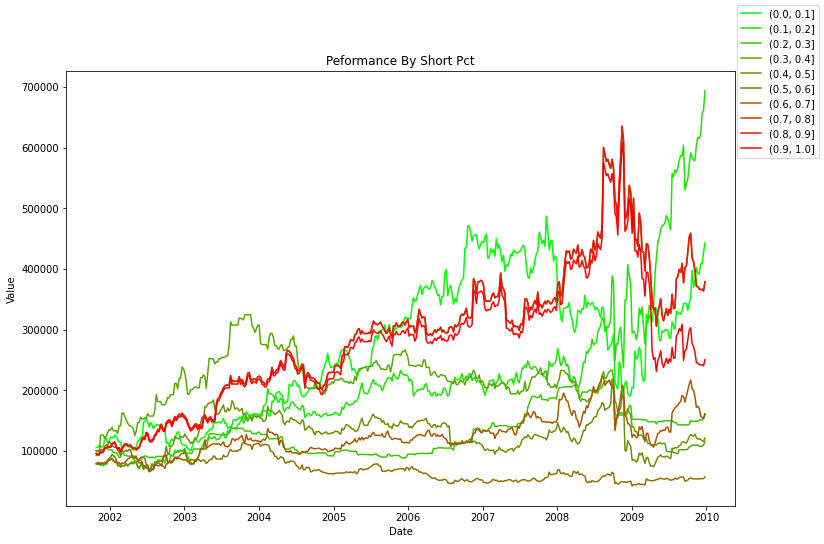

In [144]:
n_plot = len(max_perform)
red = np.linspace(0, 1, n_plot)
green = 1 - red
blue = np.full((n_plot,), 0.0)
colors = list(zip(red, green, blue))
fig = plt.figure()
ax = fig.add_subplot()
to_plot = max_perform

for i in range(n_plot):
    create_value_plot(ax, to_plot.iloc[i], colors[i], 'Sell_Bins')

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Peformance By Short Pct')
fig.set_size_inches(12, 8)
fig.legend()
    